## Import Data

In [2]:
import pandas as pd

path = "youtube_comments_climate_change/cleaned_data.csv"
data = pd.read_csv(path, sep=",", encoding='utf-8', index_col=[0])

list(data.columns)

['publishedAt', 'authorName', 'text', 'isReply', 'cleaned']

## Import Embeddings

In [1]:
import numpy as np

embeddings = np.load('embeddings.npy', mmap_mode=None, allow_pickle=False, fix_imports=True, encoding='ASCII')

## Import Libraries

In [3]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

## UMAP with default values

UMAP parameters: metric, n_components, min_dist, n_neighbors

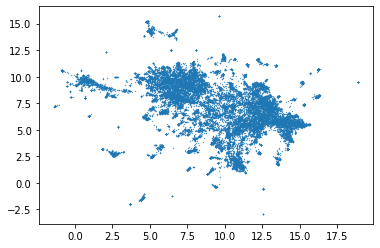

In [4]:
standard_embedding = umap.UMAP(random_state=42).fit_transform(embeddings)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], s=0.1, cmap='Spectral');

### Experiment 1: "Traditional Clustering" with KMeans

We know from previous experiments that a good number of clusters is somewhere around 60-70.

Results are okay, re silhouette score and plot.

K-Means definitely was not random, but it was also quite a long way from perfectly recovering the true labels. Part of the problem is the way K-Means works, based on centroids with an assumption of largely spherical clusters

In [5]:
kmeans_labels = cluster.KMeans(n_clusters=60).fit_predict(standard_embedding)

In [6]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_score(standard_embedding, kmeans_labels)

0.44095165

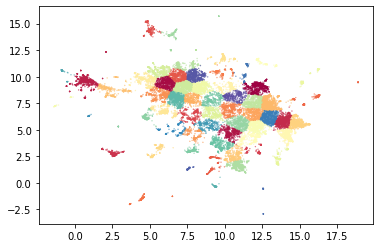

In [7]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral');

### Experiment 2: PCA and density-based algorithm HDBSCAN

HDBSCAN can refuse to cluster some points and cluster them as noise with label = 0. These "noisy" comments are colored gray in the plot.

HDBSCAN has approach of "not being wrong".

Only a small amount of points is clustered. HDBSCAN tends to suffer from the curse of dimensionality: high dimensional data requires more observed samples to produce much density. If we could reduce the dimensionality of the data more we would make the density more evident and make it far easier for HDBSCAN to cluster the data. The problem is that trying to use PCA to do this is going to become problematic. While reducing the 50 dimensions still explained a lot of the variance of the data, reducing further is going to quickly do a lot worse. This is due to the linear nature of PCA. What we need is strong manifold learning, and this is where UMAP can come into play

In [9]:
lowd_data = PCA(n_components=50).fit_transform(embeddings)
hdbscan_labels = hdbscan.HDBSCAN(min_samples=10, min_cluster_size=500).fit_predict(lowd_data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


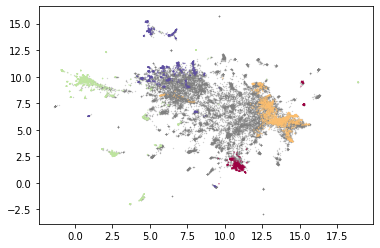

In [10]:
clustered = (hdbscan_labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=hdbscan_labels[clustered],
            s=0.1,
            cmap='Spectral');

In [11]:
print("Percent of comments clustered: {}".format(np.sum(clustered) / embeddings.shape[0]))

Percent of comments clustered: 0.187273288569885


### Experiment 3: UMAP and density-based algorithm HDBSCAN

Roughly 70% of comments are clustered.

In [12]:
clusterable_embedding = umap.UMAP(
    n_neighbors=30, #default is 15
    min_dist=0.0,
    n_components=2,
    random_state=42
).fit_transform(embeddings)

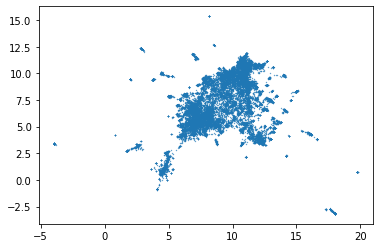

In [13]:
plt.scatter(clusterable_embedding[:, 0], clusterable_embedding[:, 1], s=0.1, cmap='Spectral');

In [16]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=50,
).fit_predict(clusterable_embedding)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


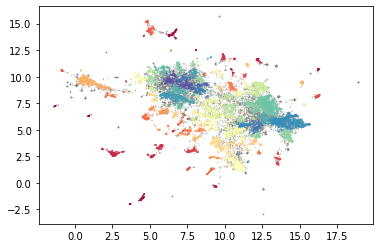

In [17]:
clustered = (labels >= 0)
plt.scatter(standard_embedding[~clustered, 0],
            standard_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(standard_embedding[clustered, 0],
            standard_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [18]:
np.sum(clustered) / embeddings.shape[0]

0.690128887859844

### Experiment 4: UMAP diagnostics

In [19]:
import umap.plot

mapper= umap.UMAP().fit(embeddings)

#### 4.1 Plotting UMAP results as points

There are no labels yet.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:>

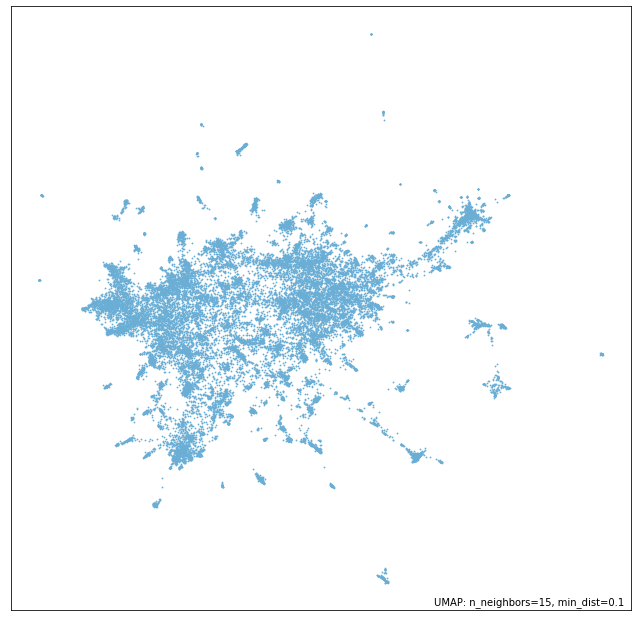

In [20]:
umap.plot.points(mapper)

<AxesSubplot:>

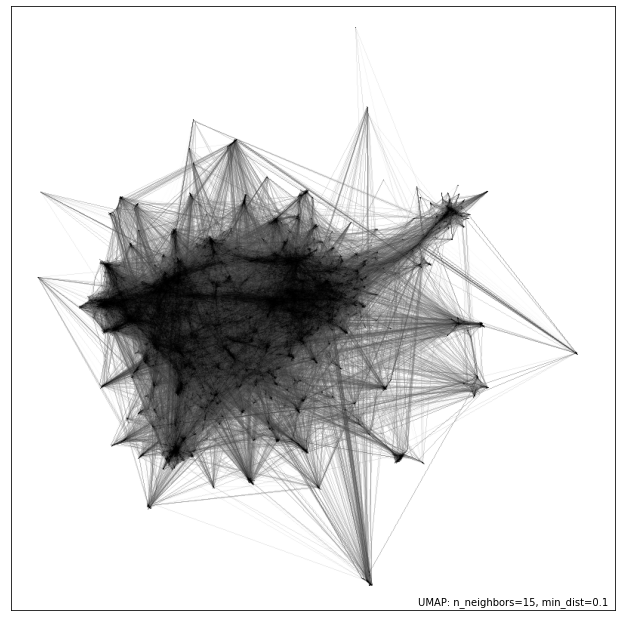

In [26]:
umap.plot.connectivity(mapper, show_points=False)

#### 4.2 Principal Components Analysis based diagnostic

PCA preserves global structure. PCA is used to reduce data to three dimensions.

Desirable: A smooth transition of colors in a layout that broadly respects color transitions. 

<AxesSubplot:title={'center':'Colored by RGB coords of PCA embedding'}>

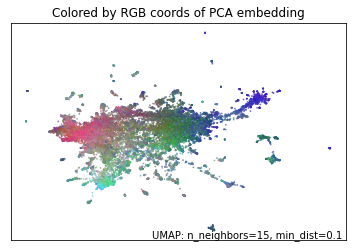

In [27]:
umap.plot.diagnostic(mapper, diagnostic_type='pca')

#### 4.3 Vector quantization based diagnostic

Similar to 4.2

Vector quantization finds 3 representative centers for the data, and then describes each data point in terms of its distance to these centers. This captures a lot of the broad global structure of the data

Desirable: Smooth transitions, related colors match between clusters

Here: Purple cluster okay, green-yellow clusters??

<AxesSubplot:title={'center':'Colored by RGB coords of Vector Quantization'}>

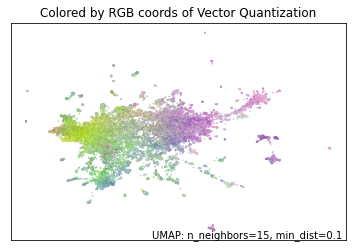

In [28]:
umap.plot.diagnostic(mapper, diagnostic_type='vq')

#### 4.4 Local dimensions based diagnostic

Approximations of the local dimension around each comment. 

Desirable: Local dimension matches embedding dimension

PSA: In practice when the local dimension is high this represents points (or areas of the space) that UMAP will have a harder time embedding as well. Thus one can trust the embedding to be more accurate in regions where the points have consistently lower local dimension.

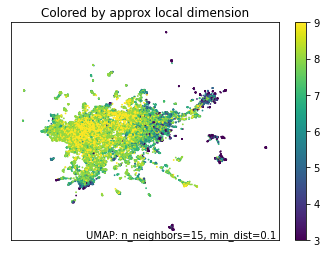

In [29]:
local_dims = umap.plot.diagnostic(mapper, diagnostic_type='local_dim')

#### 4.5 Neighborhood

Have local neighborhoods been preserved.

Desirable: Higher values

/usr/local/lib/python3.8/site-packages/umap/plot.py:206: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_nhood_compare" failed type inference due to: Use of unsupported NumPy function 'numpy.intersect1d' or unsupported use of the function.

File "../../../../../usr/local/lib/python3.8/site-packages/umap/plot.py", line 212:
def _nhood_compare(indices_left, indices_right):
    <source elided>
    for i in range(indices_left.shape[0]):
        intersection_size = np.intersect1d(indices_left[i], indices_right[i]).shape[0]
        ^

During: typing of get attribute at /usr/local/lib/python3.8/site-packages/umap/plot.py (212)

File "../../../../../usr/local/lib/python3.8/site-packages/umap/plot.py", line 212:
def _nhood_compare(indices_left, indices_right):
    <source elided>
    for i in range(indices_left.shape[0]):
        intersection_size = np.intersect1d(indices_left[i], indices_right[i]).shape[0]
        ^

  @numba.jit()
/usr/loc

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

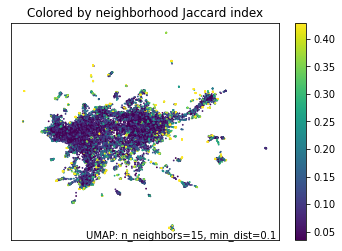

In [30]:
umap.plot.diagnostic(mapper, diagnostic_type='neighborhood')

### Experiment 5: UMAP parameters

UMAP parameters: metric, n_components, min_dist, n_neighbors

#### 5.1 metric

Universal Sentence Encoder uses angular distance, metric is set to cosine.

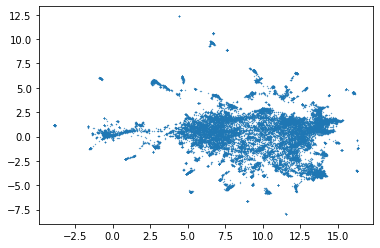

In [33]:
tuned_embedding = umap.UMAP(metric="cosine").fit_transform(embeddings)
plt.scatter(tuned_embedding[:, 0], tuned_embedding[:, 1], s=0.1)

#### 5.2 n_neighbors

How are local vs global structures balanced.
n_neighbors constrains the size of local neighborhoods UMAP looks at when learning manifold structure of data

low values: concentration on local structure (maybe detrimental to bigger picture)
high values: overall structure (might loose fine details)

From UMAP paper:
n represents some degree of trade-off between fine grained and large scale
manifold features — smaller values will ensure detailed manifold structure
is accurately captured (at a loss of the “big picture” view of the manifold),
while larger values will capture large scale manifold structures, but at a loss
of detail structure which will get averaged out in the local approximations.

I would go with 15, 5 has more by blobs separated by whitespace but I had to change init from spectral to random.

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

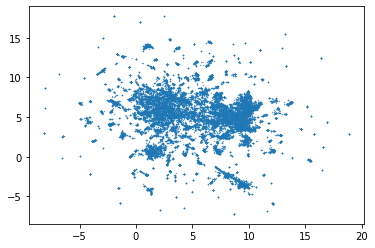

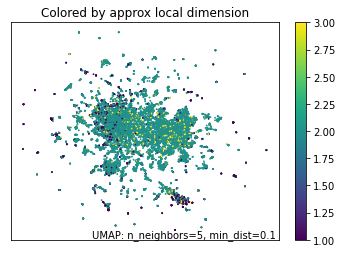

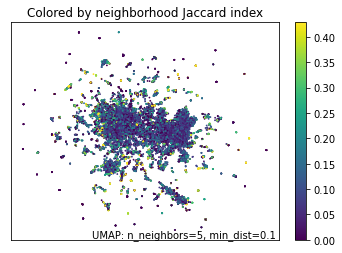

In [16]:
tmp_embedding_nnn = umap.UMAP(metric="cosine", n_neighbors=5, init='random').fit(embeddings)
plt.scatter(tmp_embedding_nnn.embedding_[:, 0], tmp_embedding_nnn.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding_nnn, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding_nnn, diagnostic_type='neighborhood')

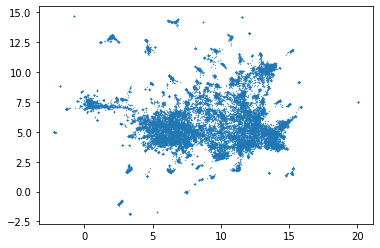

In [10]:
tmp_embedding_n = umap.UMAP(metric="cosine", n_neighbors=15).fit(embeddings)
plt.scatter(tmp_embedding_n.embedding_[:, 0], tmp_embedding_n.embedding_[:, 1], s=0.1)

<AxesSubplot:title={'center':'Colored by approx local dimension'}>

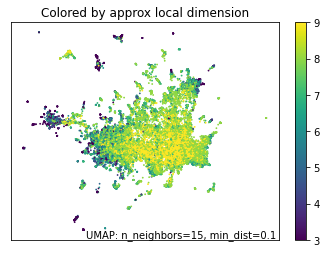

In [11]:
umap.plot.diagnostic(tmp_embedding_n, diagnostic_type='local_dim')

/usr/local/lib/python3.8/site-packages/umap/plot.py:206: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_nhood_compare" failed type inference due to: Use of unsupported NumPy function 'numpy.intersect1d' or unsupported use of the function.

File "../../../../../usr/local/lib/python3.8/site-packages/umap/plot.py", line 212:
def _nhood_compare(indices_left, indices_right):
    <source elided>
    for i in range(indices_left.shape[0]):
        intersection_size = np.intersect1d(indices_left[i], indices_right[i]).shape[0]
        ^

During: typing of get attribute at /usr/local/lib/python3.8/site-packages/umap/plot.py (212)

File "../../../../../usr/local/lib/python3.8/site-packages/umap/plot.py", line 212:
def _nhood_compare(indices_left, indices_right):
    <source elided>
    for i in range(indices_left.shape[0]):
        intersection_size = np.intersect1d(indices_left[i], indices_right[i]).shape[0]
        ^

  @numba.jit()
/usr/loc

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

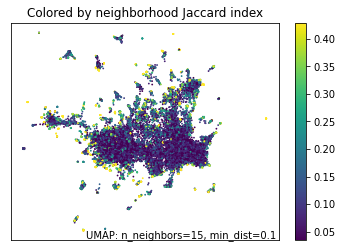

In [13]:
umap.plot.diagnostic(tmp_embedding_n, diagnostic_type='neighborhood')

<AxesSubplot:title={'center':'Colored by approx local dimension'}>

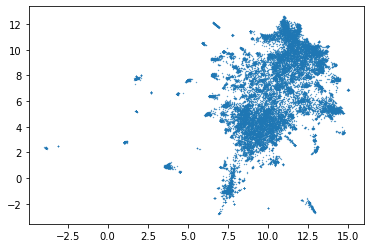

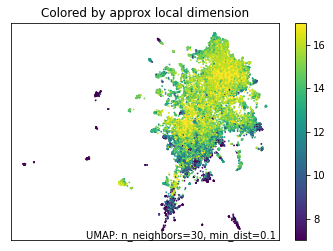

In [12]:
tmp_embedding_nn = umap.UMAP(metric="cosine", n_neighbors=30).fit(embeddings)
plt.scatter(tmp_embedding_nn.embedding_[:, 0], tmp_embedding_nn.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding_nn, diagnostic_type='local_dim')

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

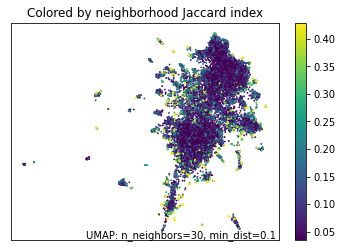

In [14]:
umap.plot.diagnostic(tmp_embedding_nn, diagnostic_type='neighborhood')

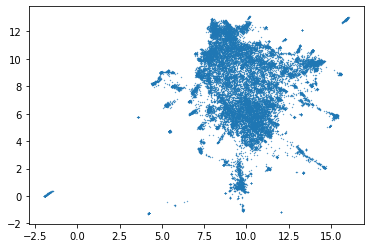

In [4]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=50).fit_transform(embeddings)
plt.scatter(tmp_embedding[:, 0], tmp_embedding[:, 1], s=0.1)

#### 5.3 min_dist

From Paper:
The min-dist parameter expands out tightly clustered groups, allowing more of the internal structure of densely
packed clusters to be seen

From API Doc:
The effective minimum distance between embedded points. Smaller values will result in a more clustered/clumped embedding where nearby points on the manifold are drawn closer together, while larger values will result on a more even dispersal of points. The value should be set relative to the spread value, which determines the scale at which embedded points will be spread out.

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

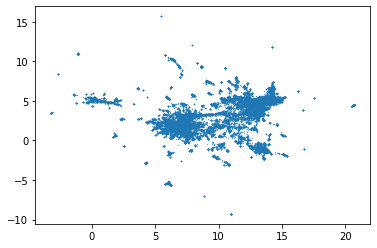

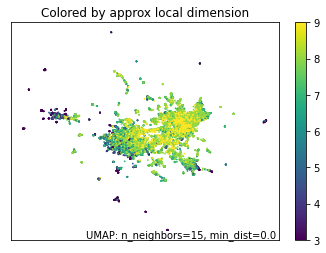

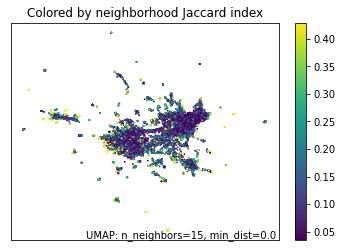

In [17]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.0).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

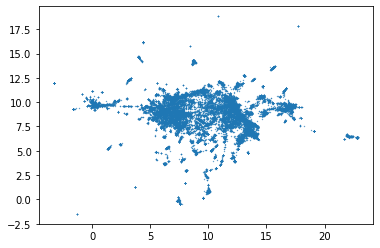

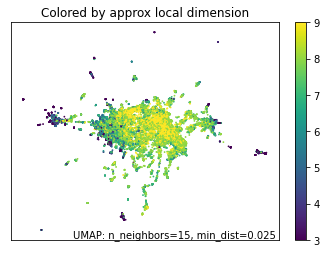

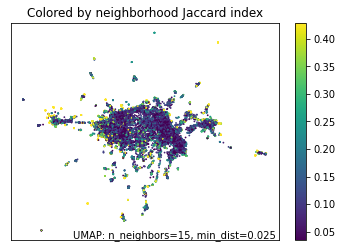

In [24]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.025).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

ValueError: Plotting is currently only implemented for 2D embeddings

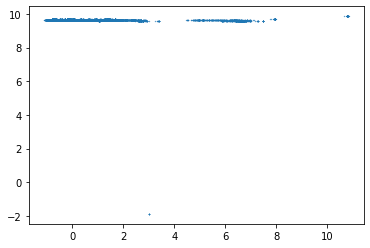

In [5]:
import umap.plot
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.05, n_components=218).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

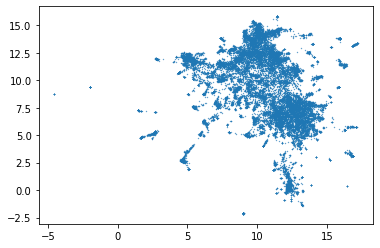

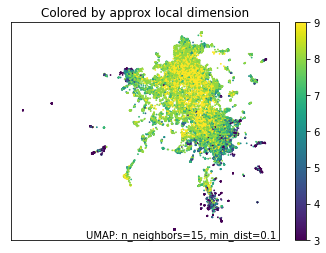

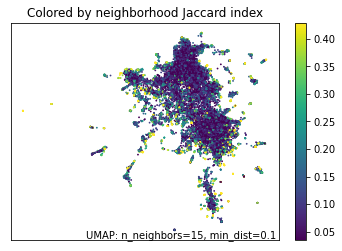

In [23]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.1).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

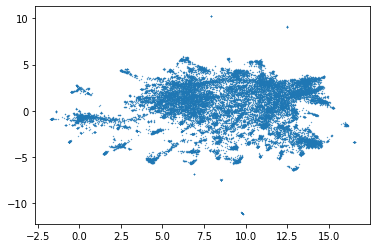

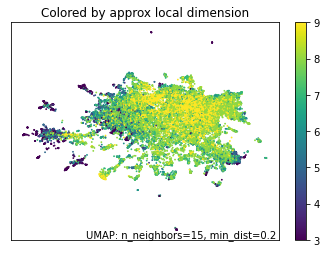

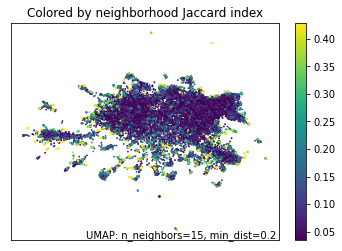

In [19]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.2).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

<AxesSubplot:title={'center':'Colored by neighborhood Jaccard index'}>

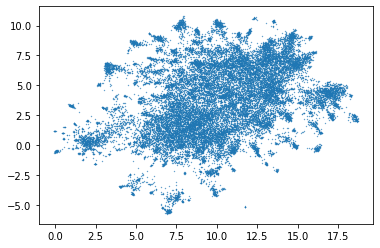

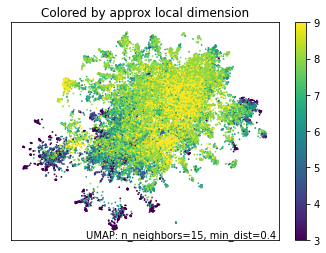

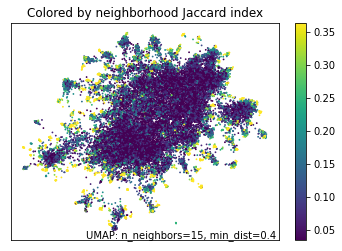

In [20]:
tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=15, min_dist=0.4).fit(embeddings)
plt.scatter(tmp_embedding.embedding_[:, 0], tmp_embedding.embedding_[:, 1], s=0.1)
umap.plot.diagnostic(tmp_embedding, diagnostic_type='local_dim')
umap.plot.diagnostic(tmp_embedding, diagnostic_type='neighborhood')

### Experiment 6: Tuned parameters with HDBSCAN

In [28]:
n_neighbors = 15
min_dist = 0.025
n_components = 218

tuned_embedding = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(embeddings)

In [29]:
labels = hdbscan.HDBSCAN(
    min_samples=10,
    min_cluster_size=50,
).fit_predict(tuned_embedding)

In [36]:
n_neighbors = 15
min_dist = 0.025
n_components = 2

clustered_embedding = umap.UMAP(
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components
).fit_transform(embeddings)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


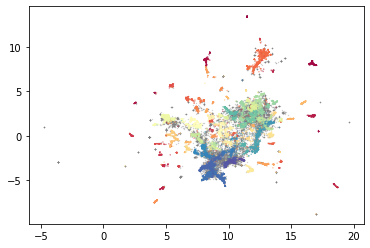

In [37]:
clustered = (labels >= 0)
plt.scatter(clustered_embedding[~clustered, 0],
            clustered_embedding[~clustered, 1],
            c=(0.5, 0.5, 0.5),
            s=0.1,
            alpha=0.5)
plt.scatter(clustered_embedding[clustered, 0],
            clustered_embedding[clustered, 1],
            c=labels[clustered],
            s=0.1,
            cmap='Spectral');

In [38]:
np.sum(clustered) / embeddings.shape[0]

0.6416608782897275

/usr/local/lib/python3.8/site-packages/umap/rp_tree.py:777: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  warn(


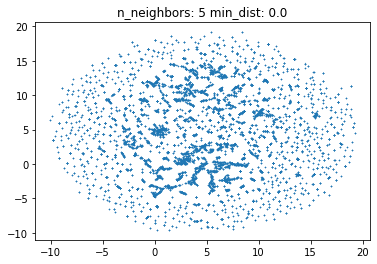

/usr/local/lib/python3.8/site-packages/umap/rp_tree.py:777: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  warn(


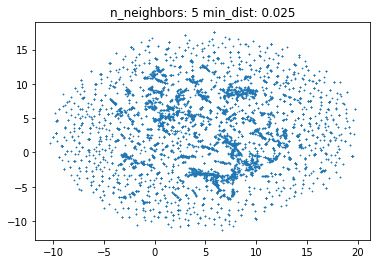

/usr/local/lib/python3.8/site-packages/umap/rp_tree.py:777: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  warn(


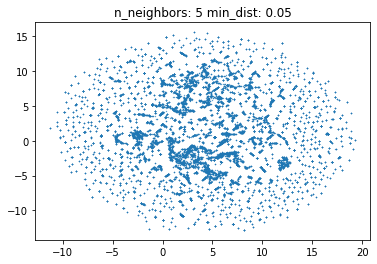

/usr/local/lib/python3.8/site-packages/umap/rp_tree.py:777: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  warn(


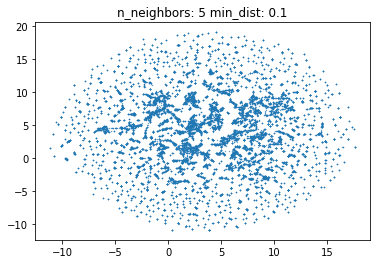

/usr/local/lib/python3.8/site-packages/umap/rp_tree.py:777: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  warn(


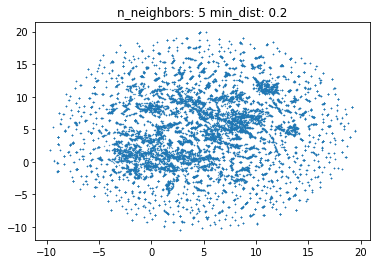

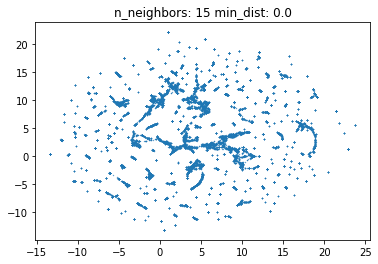

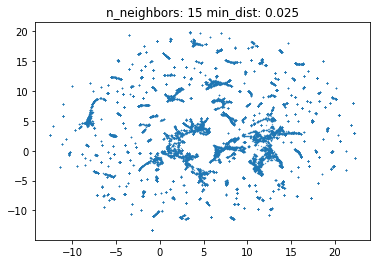

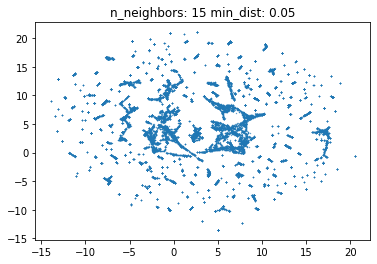

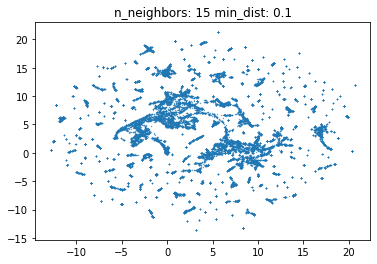

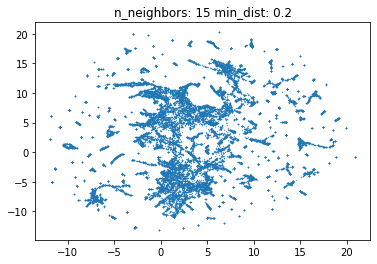

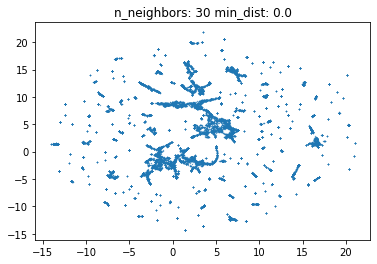

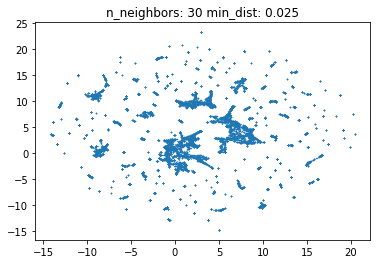

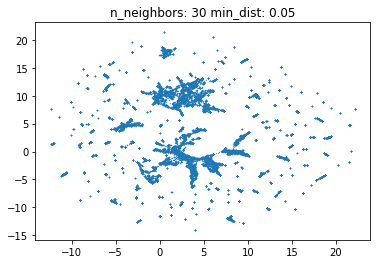

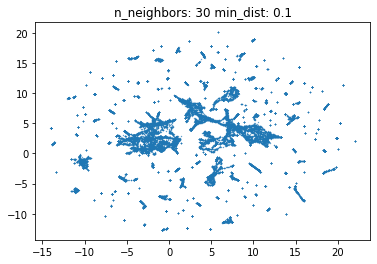

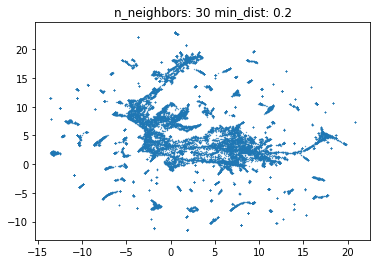

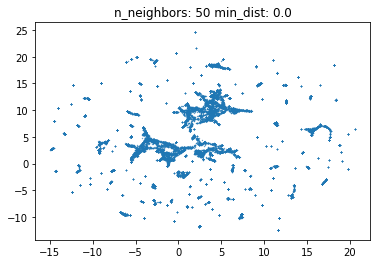

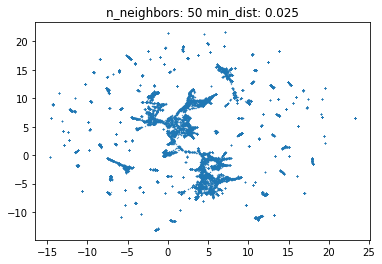

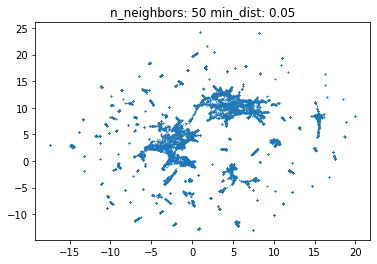

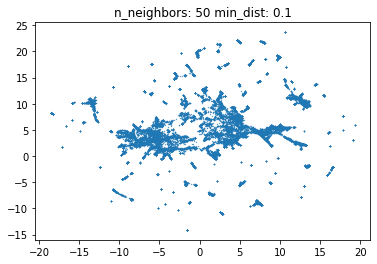

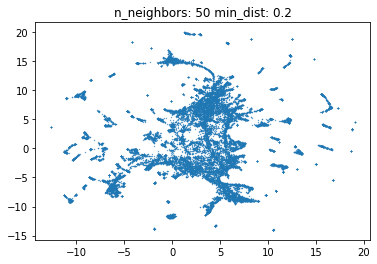

In [8]:
for i in (5, 15, 30, 50):
    for j in (0.0, 0.025, 0.05, 0.1, 0.2):
        tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=i, min_dist=j, n_components=218).fit_transform(embeddings)
        new_embedding = umap.UMAP(metric="cosine", n_neighbors=i, min_dist=j, n_components=2).fit(tmp_embedding)
        plt.scatter(new_embedding.embedding_[:, 0], new_embedding.embedding_[:, 1], s=0.1)
        plt.title("n_neighbors: {} min_dist: {}".format(i, j))
        plt.show()

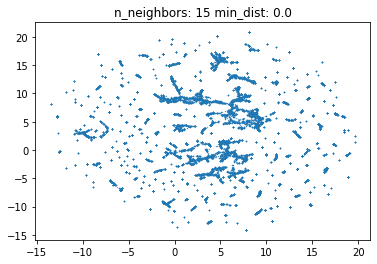

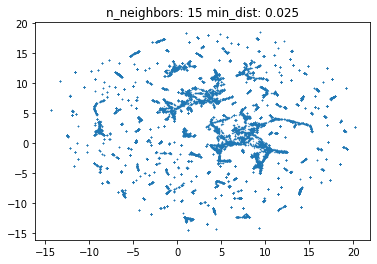

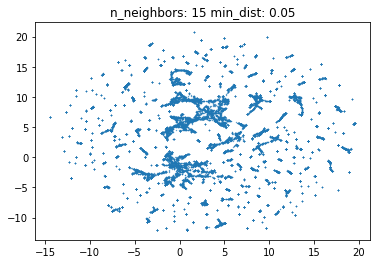

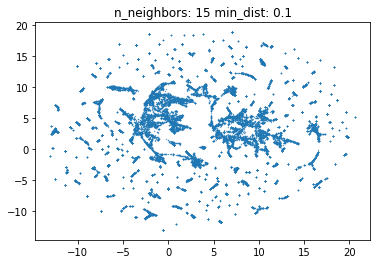

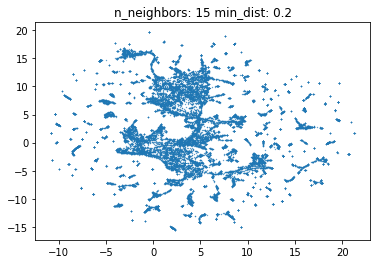

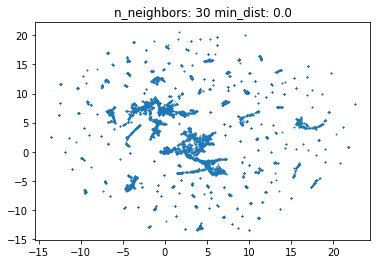

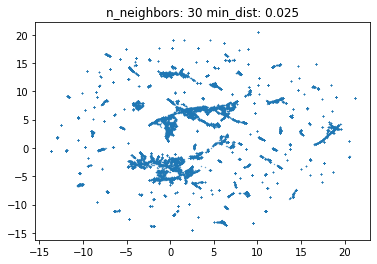

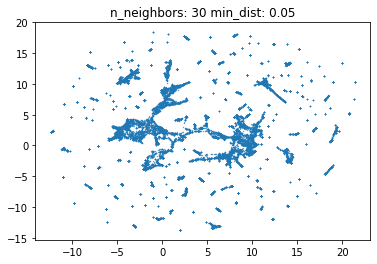

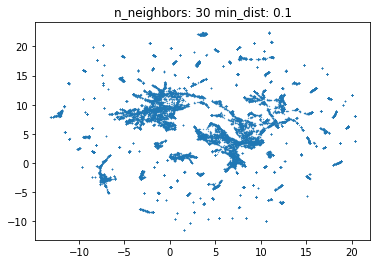

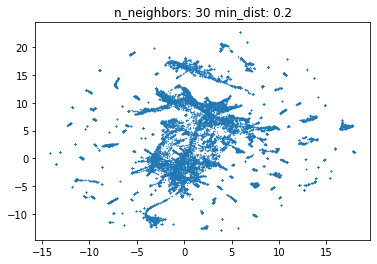

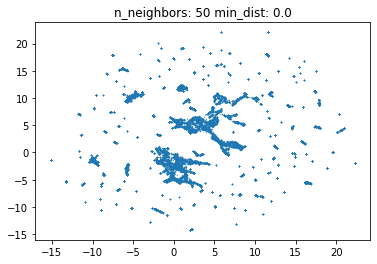

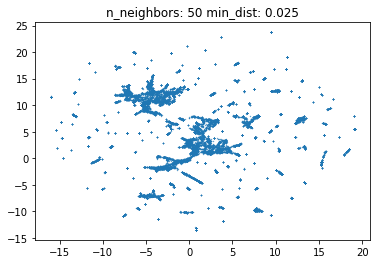

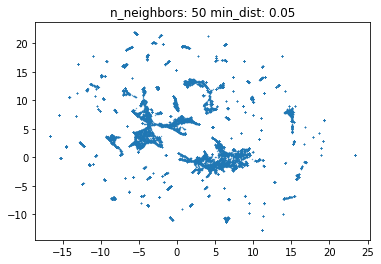

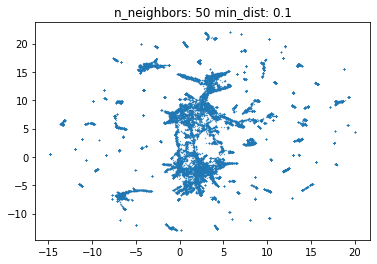

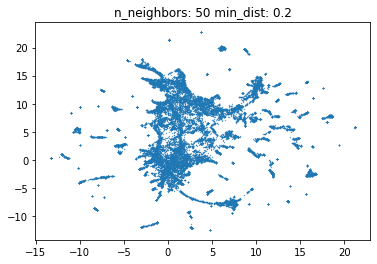

In [10]:
for i in (15, 30, 50):
    for j in (0.0, 0.025, 0.05, 0.1, 0.2):
        tmp_embedding = umap.UMAP(metric="cosine", n_neighbors=i, min_dist=j, n_components=100).fit_transform(embeddings)
        new_embedding = umap.UMAP(metric="cosine", n_neighbors=i, min_dist=j, n_components=2).fit(tmp_embedding)
        plt.scatter(new_embedding.embedding_[:, 0], new_embedding.embedding_[:, 1], s=0.1)
        plt.title("n_neighbors: {} min_dist: {}".format(i, j))
        plt.savefig('{}-{}-umap.png'.format(i,j), bbox_inches='tight')
        plt.show()